In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms

In [2]:
BATCH_SIZE = 1
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "classification.pth"

In [3]:
test_data_path = "data/Train"
data_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
])
test_data = datasets.ImageFolder(root = test_data_path, transform = data_transforms)
test_loader = data.DataLoader(test_data, shuffle=False, batch_size=1)

In [4]:
class Net(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*7*7, 1000),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Linear(in_features=1000, out_features=256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, output_dim)
        )
        
    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
model = Net(43).to(device)
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
model.eval()

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=12544, out_features=1000, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inpla

In [7]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

In [8]:
def test(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []
    
    for data, target in tqdm(test_loader):
        
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        
        if init_pred.item() != target.item():
            continue
            
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = model(perturbed_data)
        
        final_pred = output.max(1, keepdim=True)[1]
        
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples
    

In [9]:
# test(model, device, test_loader, 0.3)
accuracies = []
examples = []
# epsilons = [0.05]
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

  0%|          | 0/39209 [00:00<?, ?it/s]/opt/homebrew/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 39209/39209 [20:40<00:00, 31.61it/s]


Epsilon: 0	Test Accuracy = 38859 / 39209 = 0.9910734780280038


100%|██████████| 39209/39209 [21:07<00:00, 30.94it/s]


Epsilon: 0.05	Test Accuracy = 4051 / 39209 = 0.10331811573873345


100%|██████████| 39209/39209 [21:13<00:00, 30.80it/s]


Epsilon: 0.1	Test Accuracy = 606 / 39209 = 0.015455635185799179


100%|██████████| 39209/39209 [20:59<00:00, 31.13it/s]


Epsilon: 0.15	Test Accuracy = 147 / 39209 = 0.0037491392282384146


100%|██████████| 39209/39209 [21:44<00:00, 30.06it/s]


Epsilon: 0.2	Test Accuracy = 31 / 39209 = 0.0007906348032339514


100%|██████████| 39209/39209 [21:41<00:00, 30.12it/s]


Epsilon: 0.25	Test Accuracy = 11 / 39209 = 0.00028054783340559564


100%|██████████| 39209/39209 [21:13<00:00, 30.79it/s]

Epsilon: 0.3	Test Accuracy = 6 / 39209 = 0.0001530260909485067


In [15]:
print(len(examples[1]))

5


In [23]:
# for example in examples[1]:
#     orig, adv, ex = example
#     ex = torch.from_numpy(ex)
#     output = model(ex.to(device))

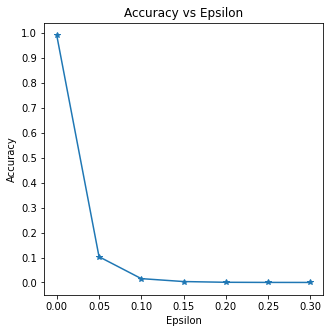

In [11]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

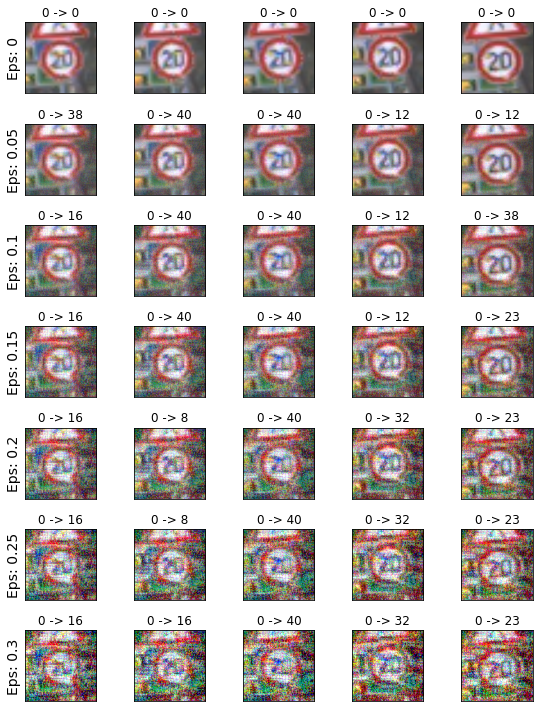

In [14]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
#         plt.imshow(ex, cmap="gray")
#         ex = np.reshape(ex, (112, 112, 3))
#         print(ex.shape)
        ex = ex.swapaxes(0,1)
        ex = ex.swapaxes(1,2)
        plt.imshow(ex)
plt.tight_layout()
plt.show()